In [7]:
# test Q-learning with function approximation
import numpy as np
import matplotlib.pyplot as plt
import gym
import mo_gym

from pymove.approx_q_learning import QLearning
from pymove.exploration import EpsilonGreedy
from pymove.scalarizations import WeightedScalarization, ELA, SFLLA, vELA, vSFLLA
from pymove.order_operators import ScalarizingOrderOperator, LexicographicOrderOperator
from pymove.exploration import SoftmaxExploration
from pymove.approximation import TileCode
from pymove.env_wrappers import PastReturnAugmented, ObjectiveSelector

import time

# environment
num_steps = 2000
gamma = 1.0
gamma_past = 0.99
#env = gym.make("food-water-balance-v0", max_steps=num_steps, gamma=gamma, gamma_past=gamma_past)
env = PastReturnAugmented(ObjectiveSelector(gym.make("breakable-bottles-v0", unbreakable_bottles=False), [1, 2]), gamma_past)

cum_rewards_range = env.observation_space["past_return"].high - env.observation_space["past_return"].low


/home/robert/miniconda3/envs/pymove/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [9]:
env.observation_space["obs"]["location"].n

5

In [10]:
env.observation_space["obs"]["bottles_carrying"].n * env.observation_space["obs"]["bottles_delivered"].n * env.observation_space["obs"]["bottles_dropped"].n * env.observation_space["obs"]["location"].n

90

In [4]:

# algorithm parameters
num_episodes = 50
alpha = 0.05
alpha_decay = 1.0
epsilon = 0.1
epsilon_decay = 0.999
epsilon_step = epsilon/num_episodes
epsilon_update_freq = 2000
use_replay = False
num_random_replays = 10

# setup features map
iht_size = 4096
num_tilings = 8
tile_size = 1/num_tilings

def state_action_parser(s, a):
    ds_dict, w = s
    ds = env.unwrapped.get_obs_idx(ds_dict)
    dsa = ds + a*env.num_observations
    return w, np.array(dsa)

float_dim_bounds = np.array([env.observation_space["past_return"].low, env.observation_space["past_return"].high])
print(float_dim_bounds.shape)
print(float_dim_bounds[1] - float_dim_bounds[0])
int_dim_bounds = np.array([[[0], [sp.n]] for sp_label, sp in env.observation_space["obs"].items()]).squeeze(axis=-1).T
print(int_dim_bounds.shape)
print(np.prod(int_dim_bounds[:, 1] + 1 - int_dim_bounds[:, 0]))
tile_code = TileCode(num_tilings, float_dim_bounds, int_dim_bounds, state_action_parser)

# setup exploration policy
#utility_function = lambda x: x
utility_function = lambda x: -np.exp(-x)
#utility_function = lambda x: np.where(x < 0, 1 - np.exp(-x), np.log(1 + x*(x >= 0)))

scalarization = WeightedScalarization(utility=vSFLLA)
order_op = ScalarizingOrderOperator(scalarization)
exploration_policy = EpsilonGreedy(env, epsilon=epsilon, decay_type="lin", decay_params={"decay_step": epsilon_step}, order_operation=order_op)

algo = QLearning(env,
            num_episodes,
            alpha,
            alpha_decay=alpha_decay,
            gamma=gamma,
            exploration_policy=exploration_policy,
            feature_map=tile_code,
            use_replay=use_replay,
            replays_per_step=num_random_replays)

algo.learn()



(2, 2)
[5000.  100.]
(2, 4)
0
Episode 0 | epsilon 0.1
Episode 1 | epsilon 0.098
Episode 2 | epsilon 0.096
Episode 3 | epsilon 0.094
Episode 4 | epsilon 0.092
Episode 5 | epsilon 0.09
Episode 6 | epsilon 0.088
Episode 7 | epsilon 0.086
Episode 8 | epsilon 0.08399999999999999
Episode 9 | epsilon 0.08199999999999999
Episode 10 | epsilon 0.07999999999999999
Episode 11 | epsilon 0.07799999999999999
Episode 12 | epsilon 0.07599999999999998
Episode 13 | epsilon 0.07399999999999998
Episode 14 | epsilon 0.07199999999999998
Episode 15 | epsilon 0.06999999999999998
Episode 16 | epsilon 0.06799999999999998
Episode 17 | epsilon 0.06599999999999998
Episode 18 | epsilon 0.06399999999999997
Episode 19 | epsilon 0.06199999999999997
Episode 20 | epsilon 0.05999999999999997
Episode 21 | epsilon 0.05799999999999997
Episode 22 | epsilon 0.055999999999999966
Episode 23 | epsilon 0.053999999999999965
Episode 24 | epsilon 0.05199999999999996
Episode 25 | epsilon 0.04999999999999996
Episode 26 | epsilon 0.0479

In [30]:
exploration_policy.epsilon

0

In [28]:
tile_code.size, tile_code.total_int_dim_size

(262144, 288)

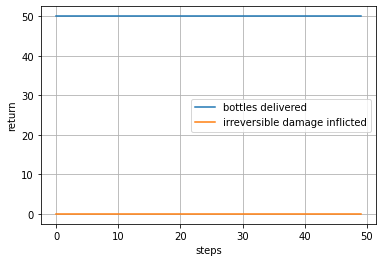

In [5]:
plt.figure()
plt.plot(algo.returns[0, :], label="bottles delivered")
plt.plot(algo.returns[1, :], label="irreversible damage inflicted")
plt.legend()
plt.xlabel("steps")
plt.ylabel("return")
plt.grid()
plt.show()

In [6]:
algo.returns

array([[50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
        50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
        50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.,
        50., 50., 50., 50., 50., 50., 50., 50., 50., 50., 50.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])